# Getting started with Amazon Braket Hybrid Jobs

This tutorial shows how to run your first Amazon Braket Hybrid Job. To get started, we consider small circuits with only one qubit and one gate.


## Learning outcomes
* Get setup to run your first job
* Write an algorithm script to run on Braket Jobs
* Understand how to run scripts or functions
* Create a job on Braket simulators or QPUs
* Monitoring the job state
* Save results from a job
* Using a specific AWS session
* Running jobs with priority on QPUs
* Use local jobs to quickly test and debug scripts
* Create a Braket Job using the Braket console

## Getting setup to run Braket Jobs

When you use Amazon Braket Hybrid Jobs for the first time, you need to create an IAM role with the right [permissions](https://docs.aws.amazon.com/braket/latest/developerguide/braket-manage-access.html#about-amazonbraketjobsexecution). This role allows your job to perform actions on your behalf while it is executing your algorithm, for instance, access S3 to return the results of your job. To create the role or check if you already have one please visit the Permissions tab from the left menu of the Braket Console.

## Writing an algorithm script

To create a Braket Job, you first need a Python script to run. In this example, it's contained in `algorithm_script.py`. The script is printed in the code cell below for convenience. 

As shown, each of the circuits has only one $X$ rotation gate with a random angle. The circuit is repeated five times with different random rotations. Note that the algorithm script does not specify the backend Amazon Braket device ARN explicitly. Instead, it is provided through environment variables such as `os.environ["AMZN_BRAKET_DEVICE_ARN"]` that are passed to the algorithm script when creating the job. 

#### This block is a copy of the algorithm script.

```python

import os
import numpy as np

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.jobs import save_job_result
from braket.tracking import Tracker

t = Tracker().start()

print("Test job started!")

# Use the device declared in the creation script
device = AwsDevice(os.environ["AMZN_BRAKET_DEVICE_ARN"])

counts_list = []
angle_list = []
for _ in range(5):
    angle = np.pi * np.random.randn()
    random_circuit = Circuit().rx(0, angle)

    task = device.run(random_circuit, shots=100)
    counts = task.result().measurement_counts

    angle_list.append(angle)
    counts_list.append(counts)
    print(counts)

# Save the variables of interest so that we can access later
save_job_result({"counts": counts_list, "angle": angle_list, "estimated cost": t.qpu_tasks_cost() + t.simulator_tasks_cost()})

print("Test job completed!")
```

## Creating your first job

Once the script is finalized, you can create a Braket Job with `AwsQuantumJob`. When the job is created, Amazon Braket starts the job instance (based on EC2) and spins up a Docker container to run your algorithm script. Other configurations can be specified via keyword arguments. See the [developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/what-is-braket.html) and other example notebooks to learn more about how to customize your jobs

This example uses the following inputs for `AwsQuantumJob`:
- <b>device</b>: The ARN of the Braket simulator or QPU to use in the job. It will be passed as an environment variable to the algorithm script. 
- <b>source_module</b>: The path to a file or a Python module that contains your algorithm script. It will be uploaded to the container for running the Braket Job.
- <b>wait_until_complete (optional)</b>: If True, the function call will wait until the Braket Job is completed and will additionally print logs to the local console. Otherwise, it will run asynchronously. The default is False.

In [2]:
from braket.aws import AwsQuantumJob

In [3]:
# This cell should take about 5 mins
job = AwsQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="algorithm_script.py",
    wait_until_complete=True,
)

Initializing Braket Job: arn:aws:braket:<region>:<account-id>:job/<job-name>
...............................................
2021-11-10 20:55:24,467 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {},
    "current_host": "algo-1",
    "framework_module": null,
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {},
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {},
    "input_dir": "/opt/ml/input",
    "is_master": true,
    "job_name": "BraketJob-<account-id>-<job-name>",
    "log_level": 20,
    "master_hostname": "algo-1",
    "model_dir": "/opt/ml/model",
    "module_dir": "/opt/ml/code",
    "module_name": "braket_container",
    "network_interface_name": "eth0",
    "num_cpus": 2,
    "num_gpus": 0,
    "output_data_dir": "/opt/ml/output/data",
    "output_dir": "/opt/ml/output",
    "output_intermediate_dir": "/opt/ml/output/intermediate",
    "resour

In this example, the algorithm is defined by a single file, so the `source_module` is `algorithm_script.py`. Depending on your application, there are other options for setting the source module. For example, if you wish to only execute a part of `algorithm_script.py` at the start of a Braket Job, you can package that part to be a `starting_function()`. Then assign the function as the entry point by adding the `entry_point` input argument.

In [4]:
source_module = "algorithm_script.py"
entry_point = "algorithm_script:starting_function"

If your algorithm script requires other dependencies, you can put them all in one folder, say the `algorithm_folder`. The input arguments would then be

In [5]:
source_module = "algorithm_folder"
entry_point = "algorithm_folder.algorithm_script:starting_function"

## Checking job state and loading results

The status of a Braket Job can be checked by calling `job.state()`. The state will be one of "QUEUED", "RUNNING", "FAILED", "COMPLETED", "CANCELLING", or "CANCELLED". 

In [6]:
job.state()

'COMPLETED'

Once completed, the result can be retrieved using `job.result()`. Logs and metadata are also accessible via `job.logs()` and `job.metadata()`. If you lose the reference to the job object, you can always reinstantiate it using your job ARN as `job=AwsQuantumJob("your-job-arn")`. The ARN of a job can be found in the Amazon Braket Console. By default the ARN of a job will be "`arn:aws:braket:<region>:<account_id>:job/<job_name>`". 

In [7]:
results = job.result()  # will return once job.state() = "COMPLETED", should be 6 minutes
print("counts: ", results["counts"])
print("angles: ", results["angles"])

counts:  [{'1': 12, '0': 88}, {'0': 42, '1': 58}, {'0': 46, '1': 54}, {'0': 100}, {'0': 100}]
angles:  [-0.6634809825751307, 1.8729107298836103, -1.8816578492668359, -0.04308463076559567, 0.03224990551866221]


In [8]:
# print(job.logs()) # uncomment to print logs

You can also download the result to a local directory.

In [9]:
job.download_result()  # download job result to local directory

In [10]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 500, 'tasks': {'COMPLETED': 5}, 'execution_duration': 0.081, 'billed_execution_duration': 15.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.01875 USD


## Running jobs with priority on QPUs

With Braket Jobs, you can run hybrid algorithms on all QPUs available through Amazon Braket. When you select a QPU as your device, your job will have priority access for the duration of your job. Quantum tasks created as part of your job will be executed ahead of other tasks in the device queue. This reduces the risk of certain tasks being delayed or drifting calibrations on the device. 

You can seamlessly swap the SV1 simulator for a QPU by changing the device argument in `AwsQuantumJob.create()`. For instance, the code below will create a job with priority access on the Rigetti Aspen-M-3 device:
```
qpu_job = AwsQuantumJob.create(
    device="arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3",
    source_module="algorithm_script.py",
    wait_until_complete=False,
)
```
When you create the job, Amazon Braket will wait for the QPU to become available before initializing the job. Note that the Braket Job will automatically select the AWS region where the device is available. As mentioned earlier, the specified device is provided to the job in the environment variable `AMZN_BRAKET_DEVICE_ARN`; the script `algorithm_script.py` uses this variable to choose the Braket device to use.

## AWS Sessions

You can customize the default location where Braket Jobs saves and loads results in Amazon S3 by providing the AWS session information. The name of the S3 bucket needs to start with "amazon-braket-", and it must be in the same region as the job being created.

In [11]:
from braket.aws import AwsSession

# Set Amazon S3 bucket
aws_session = AwsSession(default_bucket="amazon-braket-bucket-name")

To create a Braket Job with this S3 bucket, pass `aws_session` as an argument to ` AwsQuantumJob.create()`:

```
job = AwsQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="algorithm_script.py",
    aws_session=aws_session # using specific S3 bucket
)
```

## Debugging with local Braket Jobs

For faster testing and debugging of your code, you can run a job locally in your own environment. This feature requires Docker to be installed in your local environment. Amazon Braket notebooks have Docker pre-installed, so you can test local jobs in hosted notebooks instantly. To install Docker in your local environment, follow these [instructions](https://docs.docker.com/get-docker/). When a local job is created for the first time, it will take longer because it needs to build the container. The subsequent runs will be faster. Note that local jobs will not be visible in the Amazon Braket Console.

To run a job in local mode, make sure the Docker daemon is running, and then simply create a `LocalQuantumJob` instead of an `AwsQuantumJob`. Local jobs always run synchronously and display the logs.

In [12]:
from braket.jobs.local.local_job import LocalQuantumJob

# This cell should take about 2 min
job = LocalQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="algorithm_script.py",
)

Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.18.33
Beginning Setup
Completed 50.5 KiB/50.5 KiB (72.5 KiB/s) with 1 file(s) remaining
...............................................
...............................................
Running Code As Subprocess
Test job started!!!!!
Counter({'0': 79, '1': 21})
Counter({'0': 84, '1': 16})
Counter({'0': 91, '1': 9})
Counter({'0': 85, '1': 15})
Counter({'1': 94, '0': 6})
Test job completed!!!!!
Code Run Finished


In [13]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 500, 'tasks': {'COMPLETED': 5}, 'execution_duration': 0.046, 'billed_execution_duration': 15.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.01875 USD


## Creating a Braket Job from the Braket console

Besides creating a Braket Job programmatically using `AwsQuantumJob.create`, there is also an option to create a job in the Braket console. Follow [this link](https://us-west-2.console.aws.amazon.com/braket/home#/job/create) to the \"Create job\" page. First, we need to give our new job a unique name. By default, Amazon Braket leverages the AmazonBraketJobsExecutionRole for your job to ensure all the necessary permissions to AWS resources exist during execution. The default S3 folder, where all inputs and outputs for your job are saved, follows the convention `amazon-braket-<region>-<account number>/jobs/<job-name>`. Amazon Braket will create the S3 bucket and folder on your behalf if it doesn't exist. You have the option to customize these defaults in the \"Advanced settings\" tab.


<div align="center"><img src="console_figures/1-create.png"/></div>
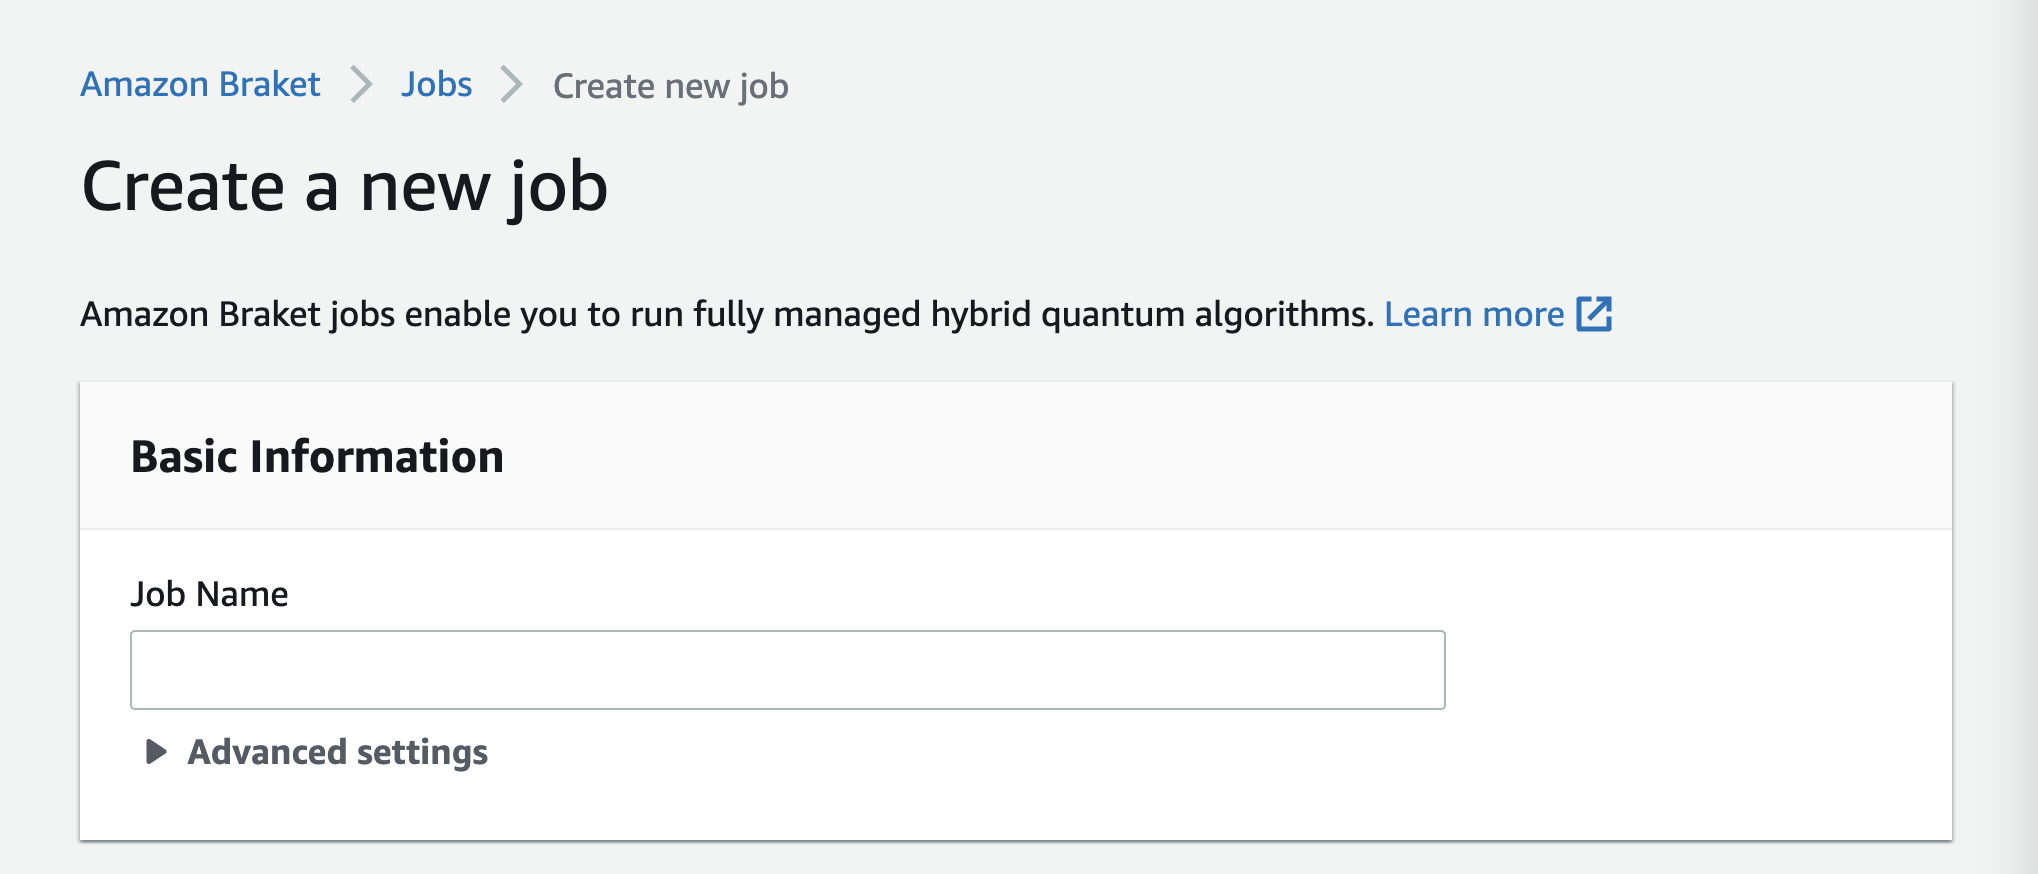

Next, select the algorithm script for the job. The script can be uploaded directly in the console as a single file. If there are many files, such as helper functions or other dependencies that go with the algorithm script, you have the option to upload the files to a S3 bucket and provide the S3 folder.

<div align="center"><img src="console_figures/2-algorithm.png"/></div>
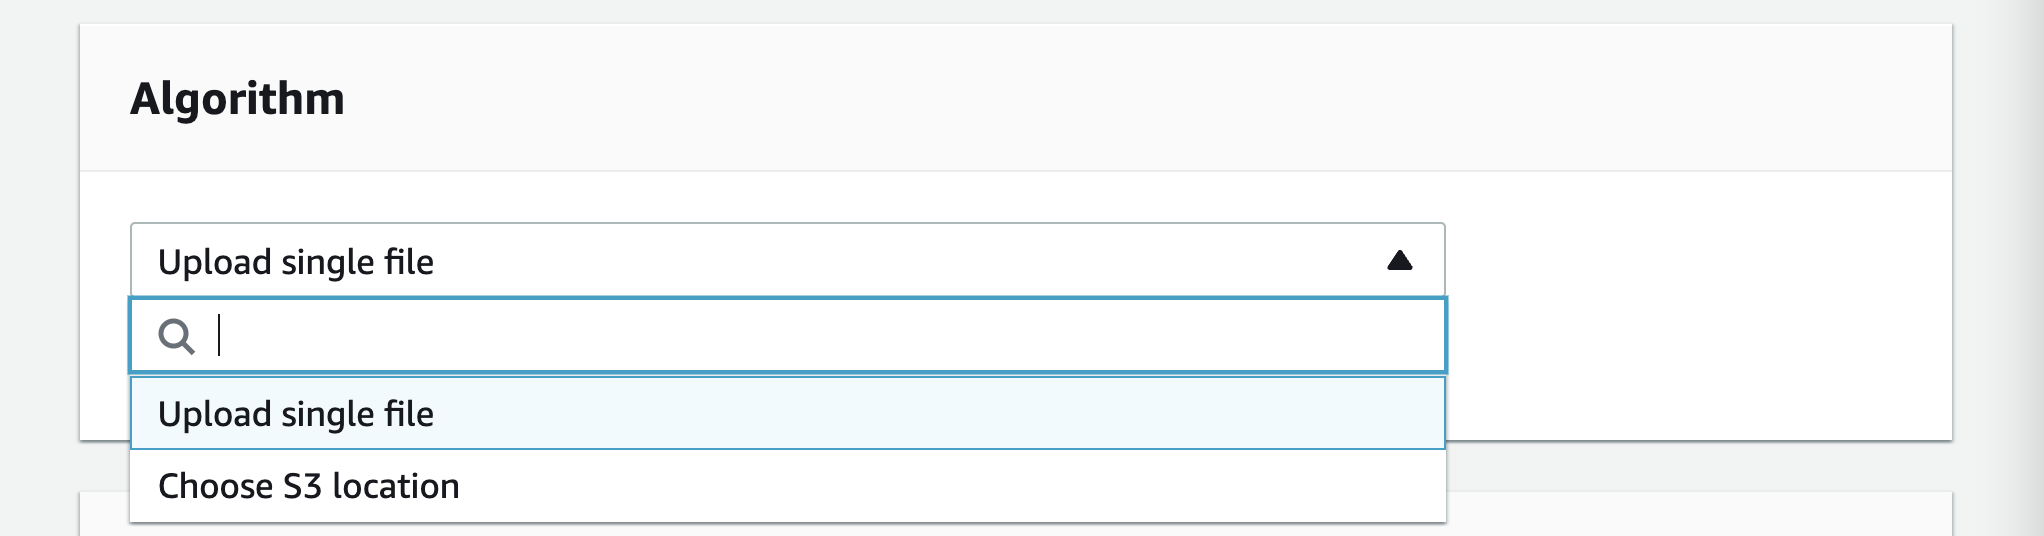

Third, select a container environment for your job. The "Base" container is enough for the example in this notebook. For information about using other pre-built or custom containers, see the Pennylane and the BYOC example notebooks. 

<div align="center"><img src="console_figures/3-container.png"/></div>
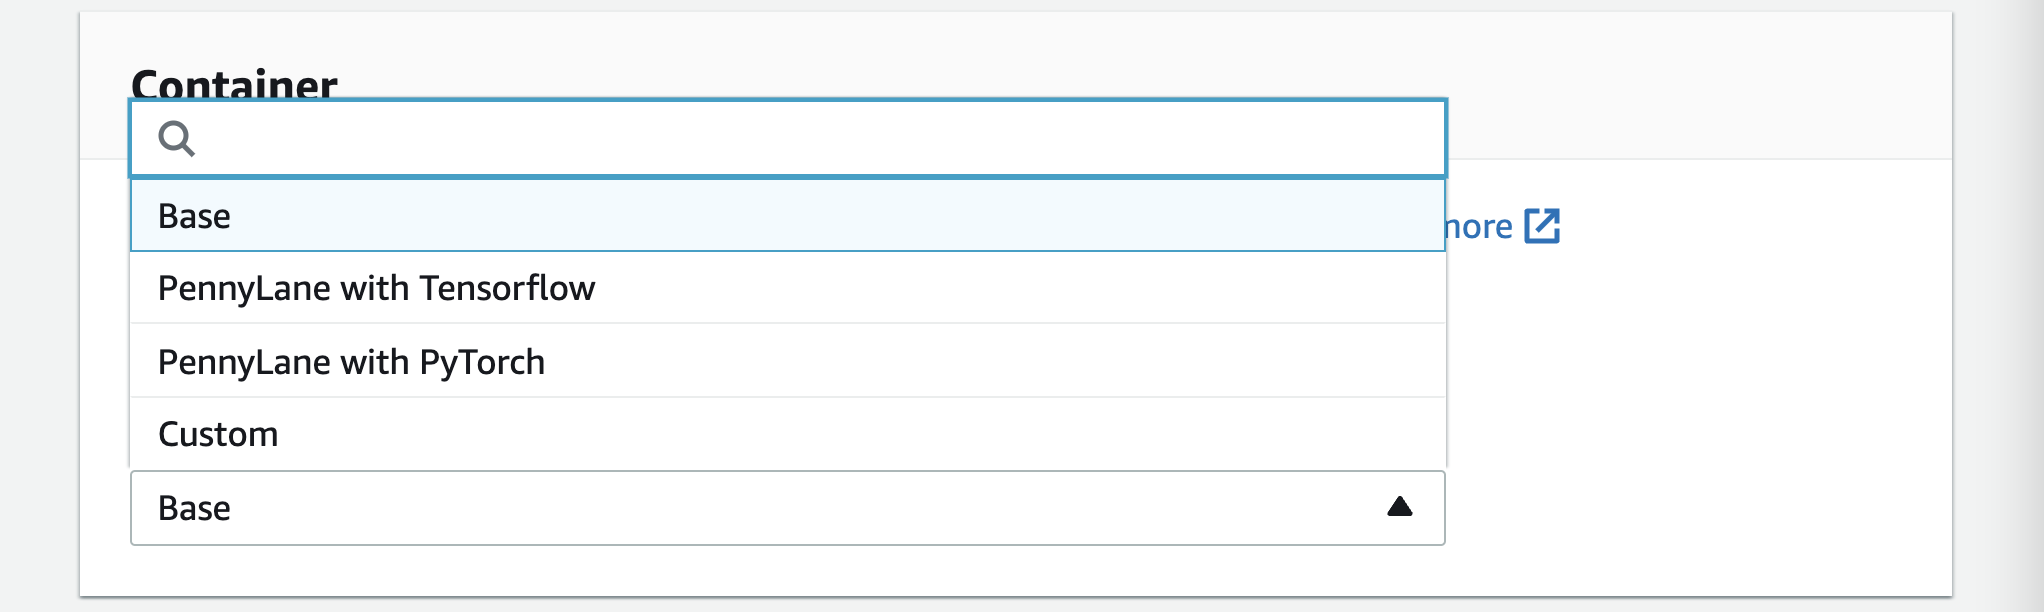

You must also select a Braket on-demand simulator or QPU for your job and configure the execution settings. Finally, there are optional hyperparameter and data inputs, as well as the possibility to customize the default locations for checkpoints and output data. We will dive deeper into these advanced use cases in other example notebooks. After finishing all the settings, you can create the job by clicking the \"Create job\" button. We can now view the progress in the Braket console.

<div align="center"><img src="console_figures/4-execution.png"/></div>
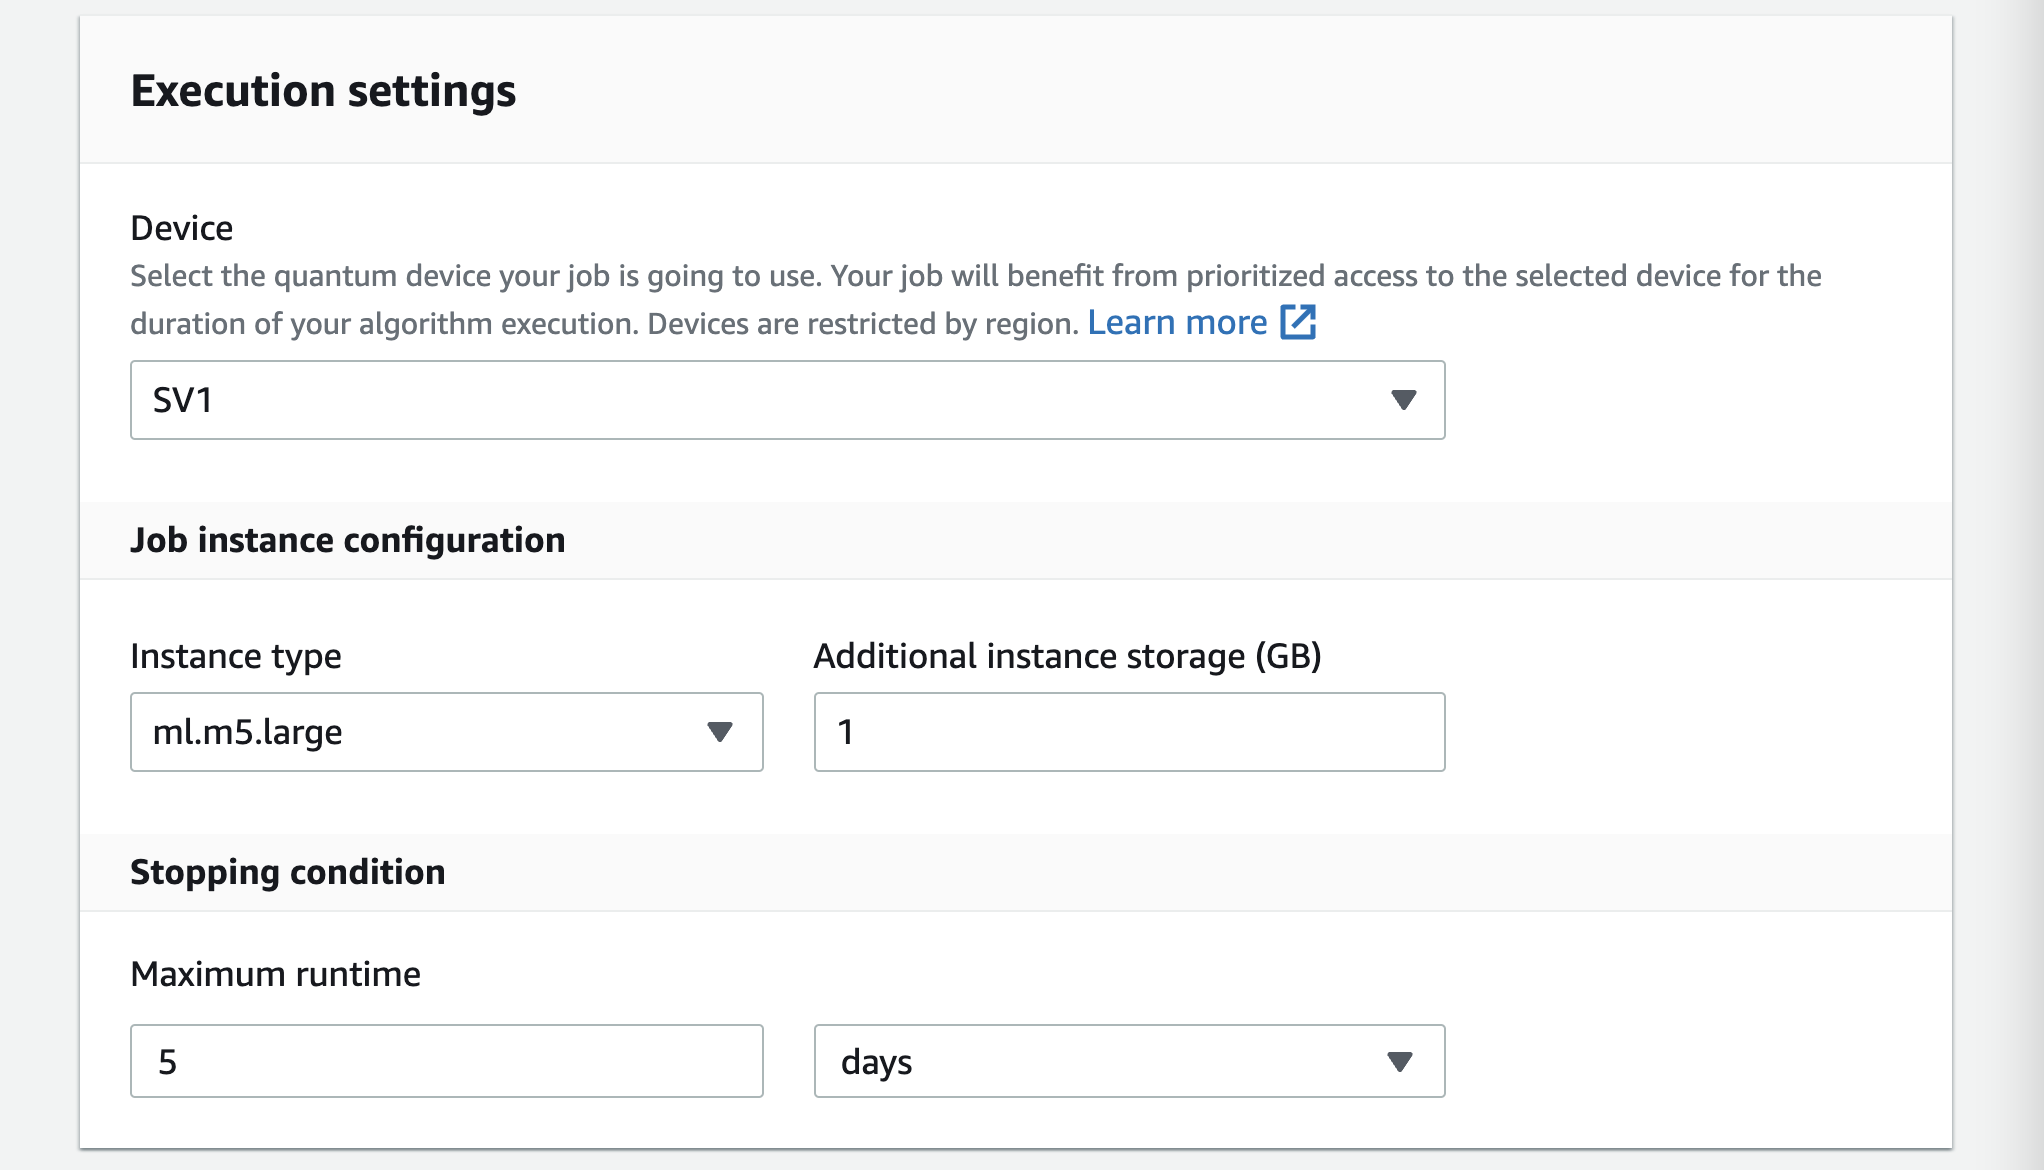

## Summary

In this tutorial, we have created our first Braket Job with a simple batch of five circuits using the Amazon Braket SDK and, as an alternative, from the Braket console. We learned how to change the Amazon S3 folder and the AWS region for a job, and how to save results. We learned how to seamlessly change the device to run on simulators or QPUs. We used local mode to quickly test code. Finally, we created the same job using the Braket console.